In [2]:
from wcps.model import Datacube
from wcps.service import Service
import requests
import urllib3
import xarray as xr
import netCDF4 as nc
import os
from dotenv import load_dotenv

# 載入 .env 文件中的環境變數
load_dotenv()

# 停用 SSL 警告（因為使用自簽名憑證）
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# 建立自訂 Service 類別，停用 SSL 驗證
class ServiceNoSSL(Service):
    def execute_raw(self, wcps_query, conn_timeout=10, read_timeout=600, stream=False):
        """Override execute_raw to disable SSL verification"""
        from wcps.model import WCPSExpr
        from requests import HTTPError
        
        # prepare request parameters
        if isinstance(wcps_query, WCPSExpr):
            wcps_query = str(wcps_query)
        url = self.endpoint_wcps + wcps_query

        # make request with verify=False to disable SSL verification
        response = requests.get(url,
                                auth=self.auth,
                                timeout=(conn_timeout, read_timeout),
                                stream=stream,
                                verify=False)  # 停用 SSL 驗證

        # check for errors from the server
        try:
            response.raise_for_status()
        except HTTPError as ex:
            err = self._parse_error_xml(response.text)
            if err is not None:
                from wcps.model import WCPSClientException
                raise WCPSClientException(err) from ex
            raise ex

        return response



# 從環境變數讀取認證資訊和服務器地址
USERNAME = os.getenv("RASDAMAN_USERNAME")
PASSWORD = os.getenv("RASDAMAN_PASSWORD")
RASDAMAN_ENDPOINT = os.getenv("RASDAMAN_ENDPOINT")


# 建立 service (帶入 username 和 password，並停用 SSL 驗證)
svc = ServiceNoSSL(RASDAMAN_ENDPOINT, username=USERNAME, password=PASSWORD)



In [3]:
# 建立 coverage 物件
cov = Datacube("qpesums_2021_all")


# 針對一個測站點（lon, lat）：
query = cov[
    "latitude": 25,         # slice 經度
    "longitude":  121.5,         # slice 緯度
    "ansi": "2021-06-04":"2021-06-05"  # trim 時間區間
]

# 指定輸出格式為 CSV
query_encoded = query.encode("text/csv")

# 執行查詢
result = svc.execute(query_encoded, convert_to_numpy=False)


# 執行查詢
result_nc = svc.execute(query.encode("application/netcdf"), convert_to_numpy=False)



# 使用 result.value 作為數據源
data = result_nc.value

# 從 netCDF4 Dataset 轉換為 xarray Dataset
# 重要：在 with 塊內加載數據到內存，這樣即使 Dataset 關閉，數據仍然可用
with nc.Dataset("memory", mode="r", memory=data) as nc_dataset:
    ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
    # 加載數據到內存（關鍵步驟！）
    ds = ds.load()
    print("✅ 成功讀取 NetCDF 數據並加載到內存")
    print(f"\n數據集信息:")
    print(ds)
    print(f"\n數據變量: {list(ds.data_vars)}")
    print(f"座標: {list(ds.coords)}")
    print(f"數據維度: {dict(ds.sizes)}")

✅ 成功讀取 NetCDF 數據並加載到內存

數據集信息:
<xarray.Dataset> Size: 3kB
Dimensions:  (ansi: 288)
Coordinates:
  * ansi     (ansi) datetime64[ns] 2kB 2021-06-04 ... 2021-06-05T23:50:00
Data variables:
    MaxDBZ   (ansi) float32 1kB -99.0 -99.0 -99.0 -99.0 ... -99.0 -99.0 -99.0
Attributes:
    Title:    Taiwan Radar Maximum Reflectivity (Processed)

數據變量: ['MaxDBZ']
座標: ['ansi']
數據維度: {'ansi': 288}


In [4]:
# 查看結果類型
print(f"結果類型: {type(result)}")
print(f"結果類型 (WCPS): {result.type}")
print(f"原始值類型: {type(result.value)}")
print()

# 將字節串解碼為字符串
if isinstance(result.value, bytes):
    csv_string = result.value.decode('utf-8')
    print(f"CSV 字符串: {csv_string}")
    print()
    
    # 轉換為數值列表
    values = [float(x) if x.strip() else None for x in csv_string.split(',')]
    print(f"數值列表 ({len(values)} 個值): {values}")
    print()
    
    # 檢查缺失值（-99 通常是缺失值標記）
    missing_count = values.count(-99.0)
    valid_count = len(values) - missing_count
    print(f"有效值數量: {valid_count}")
    print(f"缺失值數量 (-99): {missing_count}")
    print()
    
    # 如果有有效值，顯示統計資訊
    valid_values = [v for v in values if v != -99.0]
    if valid_values:
        print(f"有效值範圍: {min(valid_values):.2f} ~ {max(valid_values):.2f}")
        print(f"有效值平均: {sum(valid_values)/len(valid_values):.2f}")
    else:
        print("⚠️  所有值都是 -99（缺失值）")
        print("這可能表示：")
        print("  1. 該位置在指定時間範圍內沒有數據")
        print("  2. 座標點不在數據覆蓋範圍內")
        print("  3. 時間範圍內該位置的值都是缺失的")
else:
    print(f"結果值: {result.value}")

# 將結果保存到 CSV 文件
if isinstance(result.value, bytes):
    with open("station_ABC.csv", "wb") as f:
        f.write(result.value)
    print("\n✅ 數據已保存到 station_ABC.csv")

結果類型: <class 'wcps.service.WCPSResult'>
結果類型 (WCPS): array
原始值類型: <class 'bytes'>

CSV 字符串: -99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,35.5,34,42.7,49.4,52.8,39.5,41,50.9,48.5,48.1,45.7,28.5,33.5,38.8,46.4,45.4,45.6,43.3,45,45.8,36.9,35.2,36.5,44.4,32.1,32.8,39.5,38.8,33.5,29.1,35.5,35.7,33.3,34.5,31.2,29.7,28.7,30.4,23.2,27.3,14.9,38.5,36.4,32.2,40.2,21.7,24.5,24.5,24.5,38.9,39.6,33.9,19,22,22.6,-11,-99,-99,-99,6.5,22,37.4,19.8,26.3,24.5,38,11.5,8.5,14.5,20,15,25.7,27.8,30,25.9,21.4,12.5,-99,25,29.5,19.5,11.5,-99,-99,4.5,5.2,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,16,-99,-99,-99,-99,-99,18,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,14.5,20,11.1,9.5,6.4,8.8,10,1.5,7.6,6.2,19.8,3.5,13.2,5.8,10.7,5,-99,5.5,-4,4,7.3,4.8,12.8,16.2,9.5,10.2,24.6,21.6,31.5,21.7,20.4,18.3,13,13.5,11.5,11,14,4.5,5.5,6,1,14.5,32.9,30.7,28.6,38,20,24.8,23.7,22.1,26.2,29.3,29.4,29.7,37.3,37.5,34.9,37.9,38.9,38.6,34.4,33.3,40.2,35.8,33.1

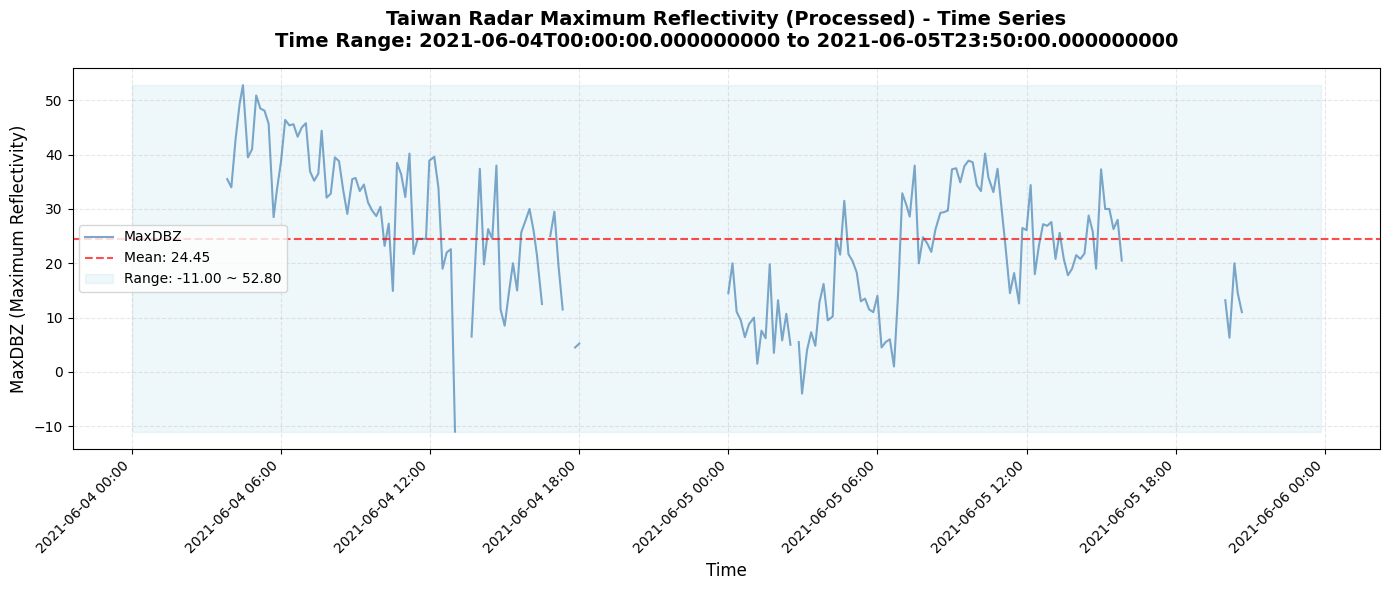


✅ Time series plot completed
Time range: 2021-06-04T00:00:00.000000000 to 2021-06-05T23:50:00.000000000
Data points: 288
Valid data points: 183
Data range: -11.00 ~ 52.80


In [5]:
# Plot MaxDBZ time series
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Ensure ds is in scope
if 'ds' not in locals():
    print("⚠️  Please run the previous cell to load data first")

# Get data
maxdbz = ds['MaxDBZ']
time = ds['ansi']

# Handle missing values (-99 is typically a missing value marker)
# Set missing values to NaN for proper display
maxdbz_clean = maxdbz.where(maxdbz > -90)

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot time series
ax.plot(time.values, maxdbz_clean.values, linewidth=1.5, alpha=0.7, color='steelblue', label='MaxDBZ')

# Add statistics lines if valid data exists
valid_data = maxdbz_clean.values[~np.isnan(maxdbz_clean.values)]
if len(valid_data) > 0:
    mean_value = np.nanmean(valid_data)
    ax.axhline(y=mean_value, color='red', linestyle='--', linewidth=1.5, 
               label=f'Mean: {mean_value:.2f}', alpha=0.7)
    
    # Add filled area showing data range
    min_value = np.nanmin(valid_data)
    max_value = np.nanmax(valid_data)
    ax.fill_between(time.values, min_value, max_value, alpha=0.2, color='lightblue', 
                    label=f'Range: {min_value:.2f} ~ {max_value:.2f}')

# Set title and labels
ax.set_title(f'{ds.attrs.get("Title", "Radar Data")} - Time Series\n'
            f'Time Range: {time.min().values} to {time.max().values}',
            fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('MaxDBZ (Maximum Reflectivity)', fontsize=12)

# Format x-axis time labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add legend
ax.legend(loc='best', fontsize=10)


plt.tight_layout()
plt.show()

print(f"\n✅ Time series plot completed")
print(f"Time range: {time.min().values} to {time.max().values}")
print(f"Data points: {len(maxdbz)}")
if len(valid_data) > 0:
    print(f"Valid data points: {len(valid_data)}")
    print(f"Data range: {min_value:.2f} ~ {max_value:.2f}")
else:
    print("⚠️  Note: All data values are -99 (missing values)")


In [6]:
from wcps.model import Datacube, Axis
from wcps.service import Service
import xarray as xr
from io import BytesIO
import netCDF4 as nc
import xarray as xr

# query_tp = cov[
#     "longitude": lon,         # slice 經度
#     "latitude":  lat,         # slice 緯度
#     "ansi": "2021-06-04":"2021-06-05"  # trim 時間區間
# ]

query_tp = cov[
    Axis("ansi", "2021-06-04T15:00:00.000Z"),  # time slice
    Axis("longitude", 120.0, 122.0),              # spatial trim in x
    Axis("latitude", 24.0, 26.0),                # spatial trim in y
]

# 指定輸出格式為 CSV
query_tp_encoded = query_tp.encode("application/netcdf")


# 執行查詢
result = svc.execute(query_tp_encoded, convert_to_numpy=False)



# 使用 result.value 作為數據源
data = result.value

# 從 netCDF4 Dataset 轉換為 xarray Dataset
# 重要：在 with 塊內加載數據到內存，這樣即使 Dataset 關閉，數據仍然可用
with nc.Dataset("memory", mode="r", memory=data) as nc_dataset:
    ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
    # 加載數據到內存（關鍵步驟！）
    ds = ds.load()
    print("✅ 成功讀取 NetCDF 數據並加載到內存")
    print(f"\n數據集信息:")
    print(ds)
    print(f"\n數據變量: {list(ds.data_vars)}")
    print(f"座標: {list(ds.coords)}")
    print(f"數據維度: {dict(ds.sizes)}")

✅ 成功讀取 NetCDF 數據並加載到內存

數據集信息:
<xarray.Dataset> Size: 106kB
Dimensions:    (latitude: 161, longitude: 161)
Coordinates:
  * latitude   (latitude) float64 1kB 26.0 25.99 25.98 ... 24.02 24.01 24.0
  * longitude  (longitude) float64 1kB 120.0 120.0 120.0 ... 122.0 122.0 122.0
Data variables:
    crs        |S1 1B b''
    MaxDBZ     (latitude, longitude) float32 104kB -99.0 -99.0 ... -99.0 -99.0
Attributes:
    Title:    Taiwan Radar Maximum Reflectivity (Processed)

數據變量: ['crs', 'MaxDBZ']
座標: ['latitude', 'longitude']
數據維度: {'latitude': 161, 'longitude': 161}


/Users/insight_ai/drive_cy12tseng/NTU/Projects/Datacube/application_of_rasdaman/.venv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
/Users/insight_ai/drive_cy12tseng/NTU/Projects/Datacube/application_of_rasdaman/.venv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
/Users/insight_ai/drive_cy12tseng/NTU/Projects/Datacube/application_of_rasdaman/.venv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 21312 (\N{CJK UNIFIED IDEOGRAPH-5340}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
/Users/insight_ai/drive_cy12tseng/NTU/Projects/Datacube/application_of_rasdaman/.venv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 2249

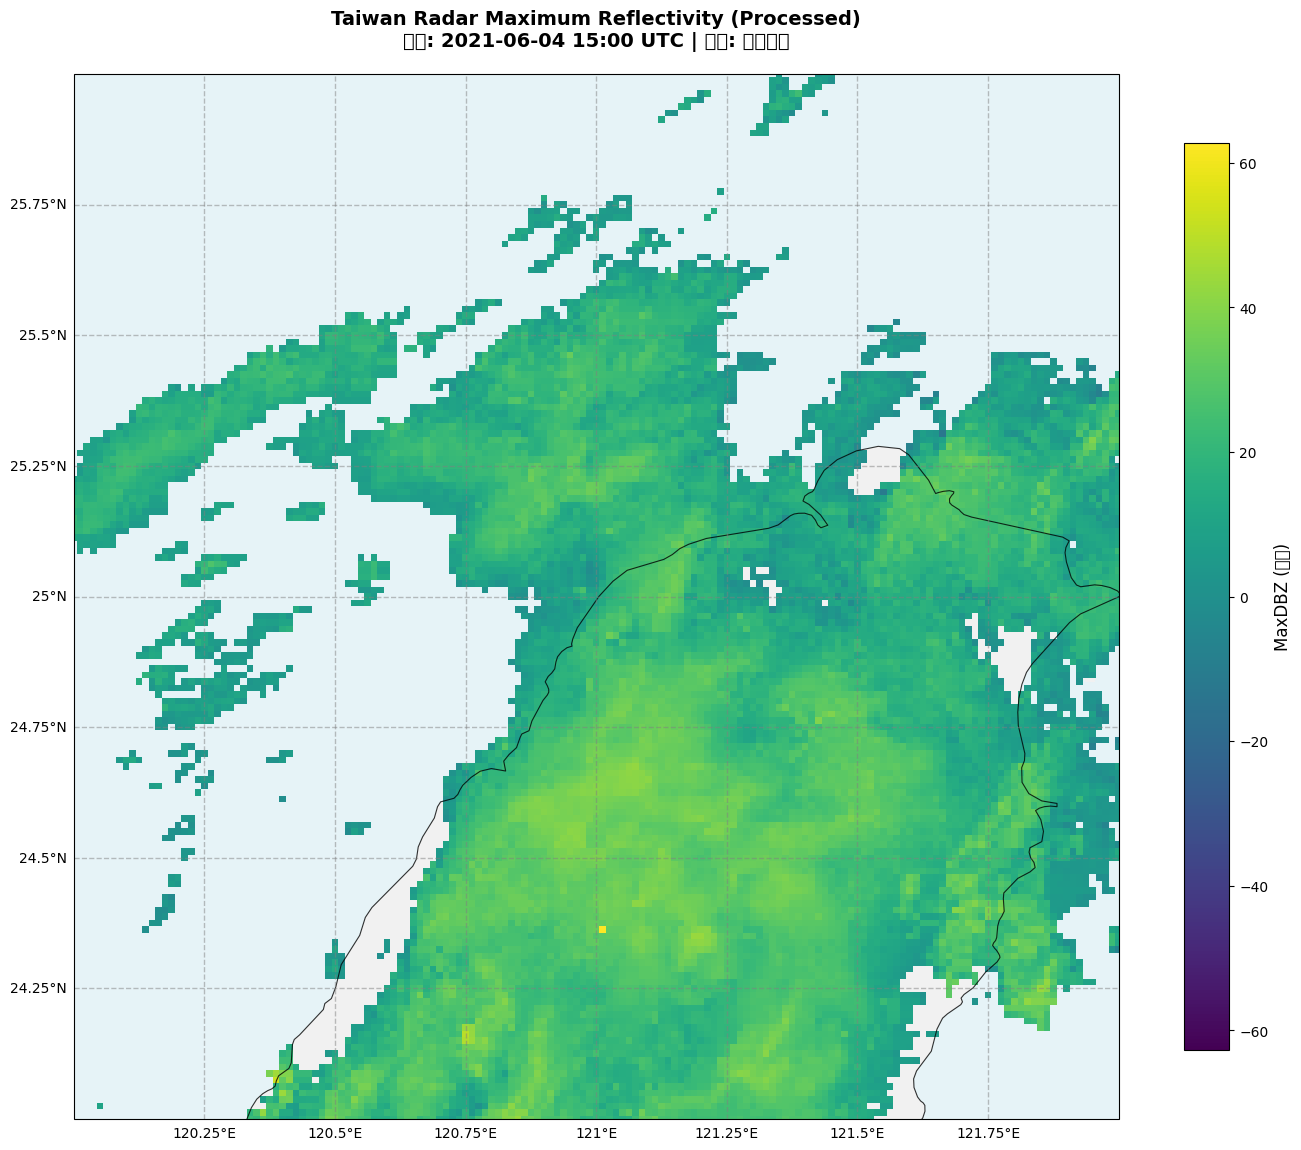

✅ 使用 Cartopy 地圖背景可視化完成


In [7]:
# 進階可視化：使用 Cartopy 顯示地圖背景（如果已安裝）
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    from matplotlib import pyplot as plt

    # 確保 ds 在作用域內
    if 'ds' not in locals():
        data = result.value
        with nc.Dataset("memory", mode="r", memory=data) as nc_dataset:
            ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
            ds = ds.load()  # 加載到內存
    
    # 獲取數據變量（排除 crs）
    data_vars = [v for v in ds.data_vars if v != 'crs']
    data_var = data_vars[0] if data_vars else list(ds.data_vars)[0]
    data_array = ds[data_var]
    data_array_clean = data_array.where(data_array > -90)
    
    # 創建帶有地圖投影的圖形
    fig = plt.figure(figsize=(14, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # 設置地圖範圍（台灣區域）
    ax.set_extent([120.0, 122.0, 24.0, 26.0], crs=ccrs.PlateCarree())
    
    # 添加地圖特徵
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, alpha=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, alpha=0.5)
    ax.add_feature(cfeature.LAND, alpha=0.3, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, alpha=0.3, facecolor='lightblue')
    
    # 繪製數據
    im = data_array_clean.plot(
        ax=ax,
        x='longitude',
        y='latitude',
        transform=ccrs.PlateCarree(),
        cmap='viridis',
        add_colorbar=False
    )
    
    # 添加顏色條
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, shrink=0.8)
    cbar.set_label(f'{data_var} (單位)', fontsize=12)
    
    # 添加網格線和標籤
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    
    
    # 設置標題
    ax.set_title(f'{ds.attrs.get("Title", "Radar Data")}\n'
                f'時間: 2021-06-04 15:00 UTC | 區域: 台灣北部',
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ 使用 Cartopy 地圖背景可視化完成")
    
except ImportError:
    print("⚠️  Cartopy 未安裝，跳過地圖背景可視化")
    print("   如需安裝: pip install cartopy")
    print("   或使用上一個 cell 的基本可視化")
except Exception as e:
    print(f"⚠️  地圖可視化出錯: {e}")
    print("   使用上一個 cell 的基本可視化")
